In [1]:
import os
import numpy
import math
from scipy import integrate
from matplotlib import pyplot
%matplotlib inline

The file with the airfoil geometry is imported using numpy.loadtxt

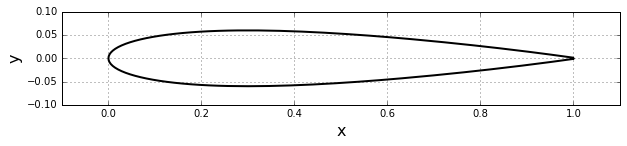

In [2]:
file_path = os.path.join('resources','naca0012.dat')
with open (file_path,'r') as file_name:
    x,y = numpy.loadtxt(file_name,unpack=True,dtype=float)

#plotting the airfoil
width = 10
pyplot.figure(figsize=(width,width))
pyplot.grid()
pyplot.xlabel('x',fontsize=16)
pyplot.ylabel('y',fontsize=16)
pyplot.plot(x,y,color = 'k',linewidth=2)
pyplot.axis('scaled',adjustable='box')
pyplot.xlim(-0.1,1.1)
pyplot.ylim(-0.1,0.1);


In [3]:
class Panel:
    """
    Contains information pertaining to a panel.
    """
    def __init__(self, xa, ya, xb, yb):
        """
        Initializes the panel.
        
        Sets the end-points and calculates the center, length,
        and angle (with the x-axis) of the panel.
        Defines if the panel is on the lower or upper surface of the geometry.
        Initializes the source-sheet strength, tangential velocity,
        and pressure coefficient to zero.
        
        Parameters
        ----------
        xa: float
            x-coordinate of the first end-point.
        ya: float
            y-coordinate of the first end-point.
        xb: float
            x-coordinate of the second end-point.
        yb: float
            y-coordinate of the second end-point.
        """
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2       # control-point (center-point)
        self.length = math.sqrt((xb-xa)**2+(yb-ya)**2)     # length of the panel
        
        # orientation of the panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.:
            self.beta = math.acos((yb-ya)/self.length)
        else:
            self.beta = math.pi + math.acos(-(yb-ya)/self.length)
        
        # location of the panel
        if self.beta <= math.pi:
            self.loc = 'upper'
        else:
            self.loc = 'lower'
        
        self.sigma = 0.                             # source strength
        self.vt = 0.                                # tangential velocity
        self.cp = 0.                                # pressure coefficient

We discretize the airfoil into a number of panels for which we define a functio below

In [17]:
def define_panels(x,y,N=40):
    """
    Discretizes the geometry into panels using the 'cosine' method.
    
    Parameters
    ----------
    x: 1D array of floats
        x-coordinate of the points defining the geometry.
    y: 1D array of floats
        y-coordinate of the points defining the geometry.
    N: integer, optional
        Number of panels;
        default: 40.
    
    Returns
    -------
    panels: 1D Numpy array of Panel objects
        The discretization of the geometry into panels.
    """
    R = (x.max()-x.min())/2
    x_center = (x.max()+x.min())/2
    x_circle = x_center + R*numpy.cos(numpy.linspace(0,2*math.pi,N+1))
    
    x_ends = numpy.copy(x_circle)                        # creating copy of variable
    y_ends = numpy.empty_like(x_ends)                    # initializing y-coordinate variable
    
    x,y = numpy.append(x,x[0]), numpy.append(y,y[0])     # extending array
    
    #computing the co-ordinate of the end points of the panels
    I = 0
    for i in range(N):
        while I < len(x)-1:
            if (x[I] <= x_ends[i] <= x[I+1]) or (x[I+1] <= x_ends[i] <= x[I]):
                break
            else:
                I += 1
        
        a = (y[I+1]-y[I])/(x[I+1]-x[I])
        b = y[I+1] - a*x[I+1]
        y_ends[i] = a*x_ends[i] + b
    
    y_ends[N] = y_ends[0]
    panels = numpy.empty(N,dtype = object)
    for i in range(N):
        panels[i] = Panel(x_ends[i],y_ends[i],x_ends[i+1],y_ends[i+1])
    return panels
    

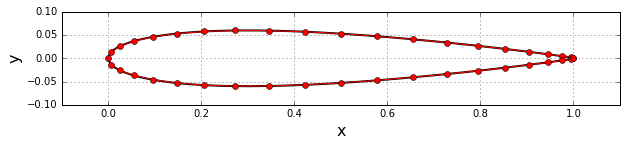

In [22]:
N = 40
panels = define_panels(x,y,N)

#plot the discretized airfoil
width = 10
pyplot.figure(figsize=(width,width))
pyplot.grid()
pyplot.xlabel('x',fontsize=16)
pyplot.ylabel('y',fontsize=16)
pyplot.plot(x,y,color='k',linewidth=2)
pyplot.plot(numpy.append([panel.xa for panel in panels],panels[0].xa),
            numpy.append([panel.ya for panel in panels],panels[0].ya),color='r',marker='o',markersize=6)
pyplot.axis('scaled',adjustable='box')
pyplot.xlim(-0.1,1.1)
pyplot.ylim(-.1,0.1);

Defining the freestream

In [23]:
class Freestream:
    """
    Freestream conditions.
    """
    def __init__(self, u_inf=1.0, alpha=0.0):
        """
        Sets the freestream speed and angle (with the x-axis).
        
        Parameters
        ----------
        u_inf: float, optional
            Freestream speed;
            default: 1.0.
        alpha: float, optional
            Angle of attack in degrees;
            default: 0.0.
        """
        self.u_inf = u_inf
        self.alpha = alpha*math.pi/180          # degrees to radians

#using defaut freesream values and creating the freestream object
freestream = Freestream()
        

Imposing the flow tangency boundary condition

In [24]:
#creating function to compute the integral
def integral(x, y, panel, dxdz, dydz):
    """
    Evaluates the contribution of a panel at one point.
    
    Parameters
    ----------
    x: float
        x-coordinate of the target point.
    y: float
        y-coordinate of the target point.
    panel: Panel object
        Source panel which contribution is evaluated.
    dxdz: float
        Derivative of x in the z-direction.
    dydz: float
        Derivative of y in the z-direction.
    
    Returns
    -------
    Integral over the panel of the influence at the given target point.
    """
    def integrand(s):
        return ( ((x - (panel.xa - math.sin(panel.beta)*s))*dxdz
                  +(y - (panel.ya + math.cos(panel.beta)*s))*dydz)
                / ((x - (panel.xa - math.sin(panel.beta)*s))**2
                   +(y - (panel.ya + math.cos(panel.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

After imposing the flow tangency boundary condition, the strength of each source panel can be found by building a linear system of equations

In [32]:
def build_matrix(panels):
    """
    Builds the source matrix
    
    Parameters
    ----------
    panels: 1D array of Panel object
        The source panels
    
    Returns
    -------
    A: 2D numpy array of floats
        The source matrix (NxN matrix; N is the number of panels)
    """
    N = len(panels)
    A = numpy.empty((N,N),dtype=float)
    numpy.fill_diagonal(A,0.5)
    
    for i,p_i in enumerate(panels):
        for j,p_j in enumerate(panels):
            if i!=j:
                A[i,j] = 0.5/math.pi*integral(p_i.xc,p_i.yc,p_j,math.cos(p_i.beta),math.sin(p_i.beta))
    return A

def build_rhs(panels,freestream):
    """
    Builds the RHS of the linear system.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        The source panels.
    freestream: Freestream object
        The freestream conditions.
    
    Returns
    -------
    b: 1D Numpy array of floats
        RHS of the linear system.
    """
    b = numpy.empty(len(panels),dtype=float)
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * math.cos(freestream.alpha - panel.beta)
    return b

In [34]:
A = build_matrix(panels)           #singulrity matrix
b = build_rhs(panels,freestream)   #freestream RHS

# solve the linear system
sigma = numpy.linalg.solve(A, b)
for i, panel in enumerate(panels):
    panel.sigma = sigma[i]

Calculating the surface pressure coefficient

In [35]:
def get_tangential_velocity(panels, freestream):
    """
    Computes the tangential velocity on the surface of the panels.
    
    Parameters
    ---------
    panels: 1D array of Panel objects
        The source panels.
    freestream: Freestream object
        The freestream conditions.
    """
    N = len(panels)
    A = numpy.empty((N, N), dtype=float)
    numpy.fill_diagonal(A, 0.0)
    
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                A[i,j] = 0.5/math.pi*integral(p_i.xc, p_i.yc, p_j, -math.sin(p_i.beta), math.cos(p_i.beta))
    
    b = freestream.u_inf * numpy.sin([freestream.alpha - panel.beta for panel in panels])
    
    sigma = numpy.array([panel.sigma for panel in panels])
    
    vt = numpy.dot(A, sigma) + b
    
    for i, panel in enumerate(panels):
        panel.vt = vt[i]

get_tangential_velocity(panels,freestream)

In [36]:
def get_pressure_coefficient(panels, freestream):
    """
    Computes the surface pressure coefficients on the panels.
    
    Parameters
    ---------
    panels: 1D array of Panel objects
        The source panels.
    freestream: Freestream object
        The freestream conditions.
    """
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

get_pressure_coefficient(panels,freestream)

In [37]:
#data from NACA report
voverVsquared=numpy.array([0, 0.64, 1.01, 1.241, 1.378, 1.402, 1.411, 1.411, 1.399, 1.378, 1.35, 1.288, 1.228, 1.166, 1.109, 1.044, 0.956, 0.906, 0])
xtheo=numpy.array([0, 0.5, 1.25, 2.5, 5.0, 7.5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 95, 100])
xtheo = xtheo/100

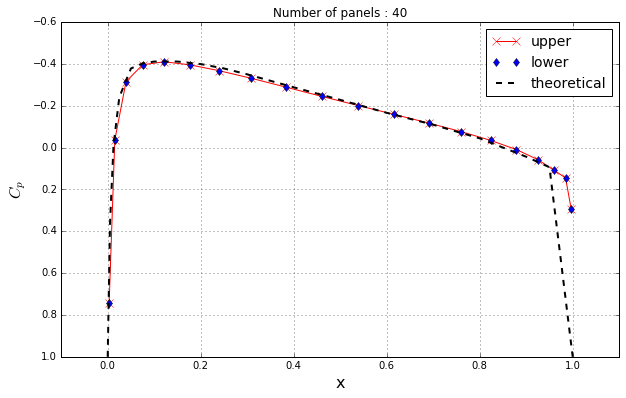

In [38]:
# plotting the result
# plot the surface pressure coefficient
pyplot.figure(figsize=(10, 6))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'upper'],
            [panel.cp for panel in panels if panel.loc == 'upper'],label='upper',color='r',marker='x',markersize=8)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'lower'],
            [panel.cp for panel in panels if panel.loc == 'lower'],label='lower',color='b',linewidth=0, 
            marker='d', markersize=6)
pyplot.plot(xtheo, 1-voverVsquared,label='theoretical',color='k', linestyle='--',linewidth=2)
pyplot.legend(loc='best', prop={'size':14})
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(1.0, -0.6)
pyplot.title('Number of panels : %d' % N);

In [39]:
# calculating the accuracy
accuracy = sum([panel.sigma*panel.length for panel in panels])
print("--> The sum of source/sink strength is :",accuracy)

--> The sum of source/sink strength is : 0.00461703117528


### Streamlines on the meshgrid

In [40]:
def get_velocity_field(panels, freestream, X, Y):
    """
    Computes the velocity field on a given 2D mesh.
    
    Parameters
    ---------
    panels: 1D array of Panel objects
        The source panels.
    freestream: Freestream object
        The freestream conditions.
    X: 2D Numpy array of floats
        x-coordinates of the mesh points.
    Y: 2D Numpy array of floats
        y-coordinate of the mesh points.
    
    Returns
    -------
    u: 2D Numpy array of floats
        x-component of the velocity vector field.
    v: 2D Numpy array of floats
        y-component of the velocity vector field.
    """
    # freestream contribution
    u = freestream.u_inf * math.cos(freestream.alpha) * numpy.ones_like(X, dtype=float)
    v = freestream.u_inf * math.sin(freestream.alpha) * numpy.ones_like(X, dtype=float)
    # add the contribution from each source
    vec_intregral = numpy.vectorize(integral)
    for panel in panels:
        u += panel.sigma / (2.0 * math.pi) * vec_intregral(X, Y, panel, 1, 0)
        v += panel.sigma / (2.0 * math.pi) * vec_intregral(X, Y, panel, 0, 1)
    
    return u, v

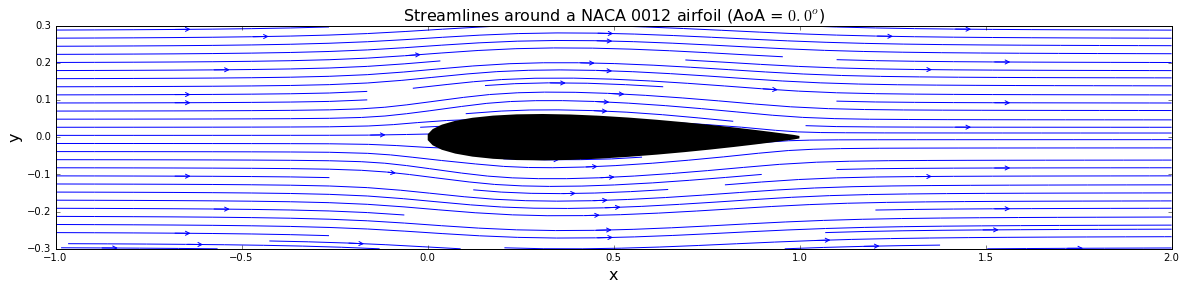

In [44]:
#defining the meshgrid
nx, ny = 20, 20  # number of points in the x and y directions
x_start, x_end = -1.0, 2.0
y_start, y_end = -0.3, 0.3
X, Y = numpy.meshgrid(numpy.linspace(x_start, x_end, nx), numpy.linspace(y_start, y_end, ny))

# compute the velocity field on the mesh grid
u, v = get_velocity_field(panels, freestream, X, Y)

#plotting the velocity field
width = 20
pyplot.figure(figsize=(width, width))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.streamplot(X, Y, u, v, density=1, linewidth=1, arrowsize=1, arrowstyle='->')
pyplot.fill([panel.xc for panel in panels],[panel.yc for panel in panels],
            color='k', linestyle='solid', linewidth=2, zorder=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.title('Streamlines around a NACA 0012 airfoil (AoA = ${}^o$)'.format(freestream.alpha), fontsize=16);

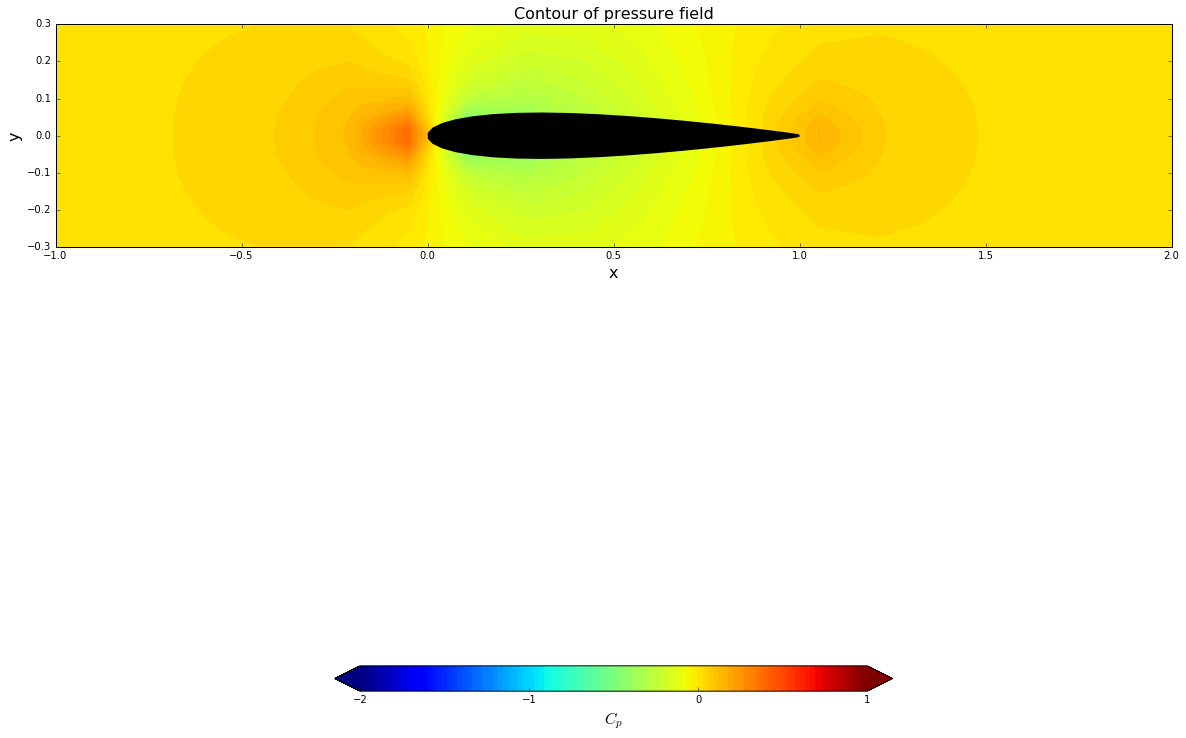

In [46]:
#compute the pressure field
# compute the pressure field
cp = 1.0 - (u**2+v**2)/freestream.u_inf**2

# plot the pressure field
width = 20
pyplot.figure(figsize=(width, width))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
contf = pyplot.contourf(X, Y, cp, levels=numpy.linspace(-2.0, 1.0, 100), extend='both')
cbar = pyplot.colorbar(contf, orientation='horizontal', shrink=0.5, pad = 0.1, ticks=[-2.0, -1.0, 0.0, 1.0])
cbar.set_label('$C_p$', fontsize=16)
pyplot.fill([panel.xc for panel in panels], [panel.yc for panel in panels],
            color='k', linestyle='solid', linewidth=2, zorder=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)Lesson 10 
pyplot.title('Contour of pressure field', fontsize=16);